In [3]:
!python -V

Python 3.10.8


In [4]:
import matplotlib.pyplot as plt
import numpy as np
from math import *
from uncertainties import *
from scipy.stats import chi2
import scipy as sp
from matplotlib import gridspec
import matplotlib
import pandas
import sys
import statsmodels.api as sm
import warnings ## statsmodels.api is too old ... -_-#
# from tqdm import tqdm

import pickle
import pgzip
import os, psutil

from IPython.display import display, clear_output

from joblib import Parallel, delayed
N_JOBS=2
from tqdm.notebook import tqdm
# from tqdm import tqdm
from datetime import datetime

import pyfftw
nthreads=2

%config InlineBackend.figure_format = 'retina'
# %config InlineBackend.figure_format = 'svg'
# %config InlineBackend.figure_format = 'pdf'
%matplotlib inline

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning) 
# warnings.filterwarnings("ignore", category=UserWarning) 
warnings.formatwarning = lambda s, *args: "Warning: " + str(s)+'\n'

plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["font.family"] = "serif" 
plt.rcParams["mathtext.fontset"] = "dejavuserif" 
plt.close("all") # close all existing matplotlib plots
# plt.ion()        # interact with plots without pausing program


In [5]:
from matplotlib.ticker import MaxNLocator

In [6]:
use_cache = False
output_prefix = "output/entangled_halo_proj/("+\
                datetime.now().strftime("%Y%m%d-%H%M%S") + "-" + \
                str("T" if use_cache else "F") + \
                ") "
output_ext = ".pgz.pkl"
print(output_prefix)

output/entangled_halo_proj/(20230207-160252-F) 


In [7]:
import platform
if not use_cache:
    with open(output_prefix + "session_info.txt", "wt") as file:
        string = ""
        string += ("="*20 + "Session System Information" + "="*20) + "\n"
        uname = platform.uname()
        string +=  f"Python Version: {platform.python_version()}\n"
        string +=  f"Platform: {platform.platform()}\n"
        string += (f"System: {uname.system}")+ "\n"
        string += (f"Node Name: {uname.node}")+ "\n"
        string += (f"Release: {uname.release}")+ "\n"
        string += (f"Version: {uname.version}")+ "\n"
        string += (f"Machine: {uname.machine}")+ "\n"
        string += (f"Processor: {uname.processor}")+ "\n"
        string +=  f"CPU Counts: {os.cpu_count()} \n"
    #     print(string)
        file.write(string)

## Simulation Parameters

In [8]:
nx = 120+1
nz = 90+1
xmax = 50 # Micrometers
# xmax = 20 * 0.001 # Millimeters
zmax = (nz/nx)*xmax
dt = 1e-3 # Milliseconds
# dt = 1e-5 # Seconds
# dt = 0.1 # Microseconds
dx = 2*xmax/(nx-1)
dz = 2*zmax/(nz-1)
hb = 63.5078 #("AtomicMassUnit" ("Micrometers")^2)/("Milliseconds")
# hb = 0.0635077993 # ("AtomicMassUnit" ("Micrometers")^2)/("Microseconds")
# hb = 0.0000635077993 #  ("AtomicMassUnit" ("Millimeters")^2)/("Milliseconds")
m3 = 3   # AtomicMassUnit
m4 = 4 

print("zmax =", zmax)
print("(dx,dz) =", (dx, dz) ) 
print("rotate phase =", 1j*hb*dt/(2*m4*dx*dz)) #want this to be small

pxmax= (nx+1)/2 * 2*pi/(2*xmax)*hb # want this to be greater than p
pzmax= (nz+1)/2 * 2*pi/(2*zmax)*hb
print("pxmax =", pxmax)
print("pzmax =", pxmax)
dpx = 2*pi/(2*xmax)*hb
dpz = 2*pi/(2*zmax)*hb
print("(dpx,dpz) = ", (dpx, dpz))

print(round((nx*nz)**2/1000/1000,3),"million grid points (ideally want around 1M magnitude)")
print(round((nx*nz)**2*0.001*0.001/60, 2),"minutes/grid_op (for 1μs/element_op)")

assert ((nx*nz)**2 < 1000**4), "This is in the terra range! too big!"

zmax = 37.60330578512397
(dx,dz) = (0.8333333333333334, 0.8356290174471994)
rotate phase = 0.011399999043956041j
pxmax = 243.40907826929285
pzmax = 243.40907826929285
(dpx,dpz) =  (3.9903127585129976, 5.305800481099699)
121.242 million grid points (ideally want around 1M magnitude)
2.02 minutes/grid_op (for 1μs/element_op)


In [9]:
wavelength = 1.083 #Micrometers
# k = (1/sqrt(2)) * 2*pi / wavelength # effective wavelength
# k = 0.03 * 2*pi / wavelength
k = pi / (8*dx)
dopd = 60.1025 # 1/ms Doppler detuning (?)
p = 2*hb*k
print("k  =",k,"1/µm")
print("p  =",p, "u*µm/ms")
v4 = hb*k/m4
print("v4 =",v4, "µm/ms")
print("sigma_x =", hb/10, " handwavy heisenberg momentum uncertainty ")
print(2*pi / (2*k), "x-period of cosin bragg lattice")

# sanity check
assert (pxmax > p*2.5 or pzmax > p*2.5), "momentum resolution too small"
assert (dpx < hb/2 and dpz < hb/2), "momentum resolution step too big"
# assert (2*pi / (2*k) > 10*dx), "not even ten x-steps in cosin wave!"

k  = 0.47123889803846897 1/µm
p  = 59.85469137769496 u*µm/ms
v4 = 7.48183642221187 µm/ms
sigma_x = 6.35078  handwavy heisenberg momentum uncertainty 
6.666666666666667 x-period of cosin bragg lattice


In [10]:
pi / (8*dx)

0.47123889803846897

In [11]:
a4 = 0.007512 # scattering length 
omega = 50 # I don't know, the nature paper used 50 for Rb
V0 = 2*hb*omega
tBraggPi = np.sqrt(2*pi*hb)/V0
# tBraggCenter = 1
tBraggCenter = tBraggPi * 5
tBraggEnd = tBraggPi * 10
print("V0 =", V0)
print("tBraggPi     =", round(tBraggPi,3),"µs")
print("tBraggCenter =", round(tBraggCenter,3),"µs")
print("tBraggEnd    =", round(tBraggEnd,3),"µs")

def V(t):
    return V0 * (2*pi)**-0.5 * tBraggPi**-1 * np.exp(-0.5*(t-tBraggCenter)**2 * tBraggPi**-2)

def VB(t, tauMid, tauPi):
        return V0 * (2*pi)**-0.5 * tauPi**-1 * np.exp(-0.5*(t-tauMid)**2 * tauPi**-2)

V0F = 50*1000
def VBF(t, tauMid, tauPi, V0FArg=V0F):
        return V0FArg * (2*pi)**-0.5 * np.exp(-0.5*(t-tauMid)**2 * tauPi**-2)
    
print(1j*(dt/hb), "term infront of Bragg potential")
print(1j*(dt/hb)*V(tBraggCenter), "max(V)")

V0 = 6350.780000000001
tBraggPi     = 0.003 µs
tBraggCenter = 0.016 µs
tBraggEnd    = 0.031 µs
1.5746097329776815e-05j term infront of Bragg potential
12.683340910935948j max(V)


In [12]:
xlin = np.linspace(-xmax,+xmax, nx)
zlin = np.linspace(-zmax,+zmax, nz)
psi=np.zeros((nx,nz, nx,nz),dtype=np.clongdouble)
psi=np.random.rand(nx,nz, nx,nz) + 1j*np.random.rand(nx,nz, nx,nz)
print(round(psi.nbytes/1000/1000 ,3) , "MB per psi 2d*2d array")

xgrid = np.tensordot(xlin, np.ones(nz), axes=0)
cosXGrid = np.cos(2*k*xgrid)
x3grid = np.tensordot(xgrid, np.ones((nx,nz)), axes=0)
x4grid = np.tensordot(np.ones((nx,nz)), xgrid, axes=0)
# cosX3Grid = np.cos(2*k*x3grid)
# cosX4Grid = np.cos(2*k*x4grid)

process = psutil.Process(os.getpid())
def current_py_memory(): return process.memory_info().rss;
def current_py_memory_print(): print(str(round(current_py_memory()/1000**2,3)) + "MB of system memory used")
momory_bytes = current_py_memory()
if (momory_bytes/1000**3 > 1): 
    warnings.warn(str(round(momory_bytes/1000**3,3))+" GB of system memory used already! careful!")
else:
    print(momory_bytes/1000**2 , "MB of system memory used")
del momory_bytes

1939.874 MB per psi 2d*2d array


In [13]:
pxlin = np.linspace(-pxmax,+pxmax,nx)
pzlin = np.linspace(-pzmax,+pzmax,nz)

expP3Grid = np.zeros((nx,nz),dtype=complex)
for indx in range(nx):
    expP3Grid[indx, :] = np.exp(-(1j/hb) * (0.5/m3) * (dt) * (pxlin[indx]**2 + pzlin**2)) 
expP4Grid = np.zeros((nx,nz),dtype=complex)
for indx in range(nx):
    expP4Grid[indx, :] = np.exp(-(1j/hb) * (0.5/m4) * (dt) * (pxlin[indx]**2 + pzlin**2)) 
# expPGrid = np.zeros((nx,nz,nx,nz),dtype=complex)
# for iz3 in range(nz):
#     for ix4 in range(nx):
#         for iz4 in range(nz):
#             expPGrid[:, :] = np.exp(-(1j/hb) * (0.5/m4) * (dt) * (pxlin[indx]**2 + pzlin**2)) 
expP3Grid = np.tensordot(expP3Grid, np.ones((nx,nz)), axes=0)
expP4Grid = np.tensordot(np.ones((nx,nz)), expP4Grid, axes=0)

In [14]:
current_py_memory_print()

7980.057MB of system memory used


### Checking parameters

39


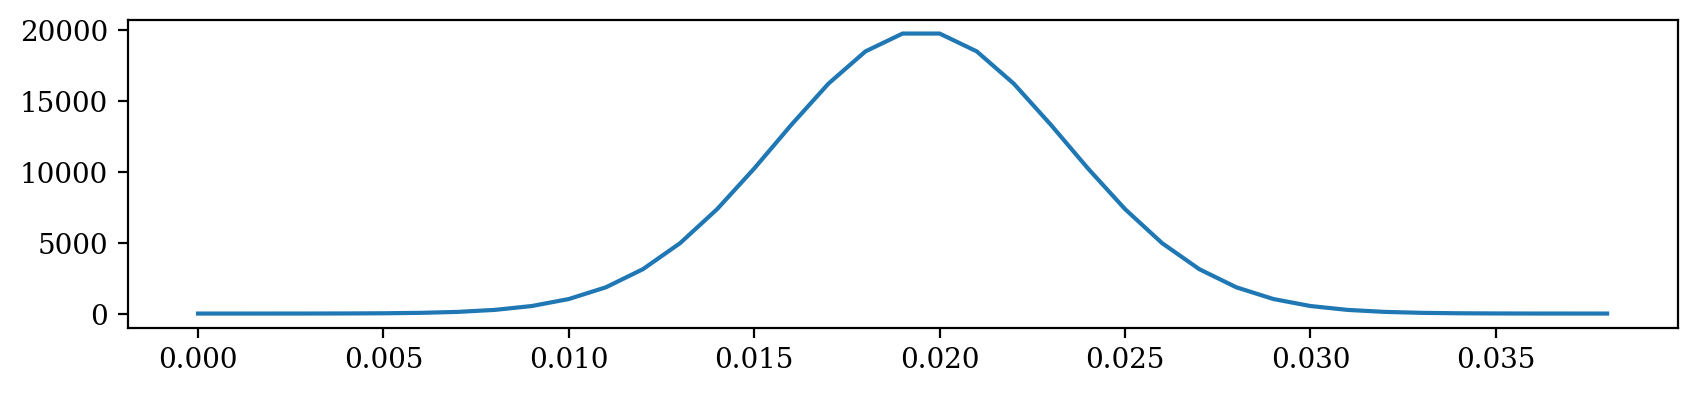

In [16]:
tauPi  = 39*0.0001
tauMid = tauPi*5
tauEnd = tauPi*10

# smooth bragg in time
tbtest = np.arange(0, tauEnd,dt)
# plt.plot(tbtest, V(tbtest))
print(tbtest.size)
plt.figure(figsize=(10,2))
plt.plot(tbtest, VBF(tbtest,tauMid,tauPi))

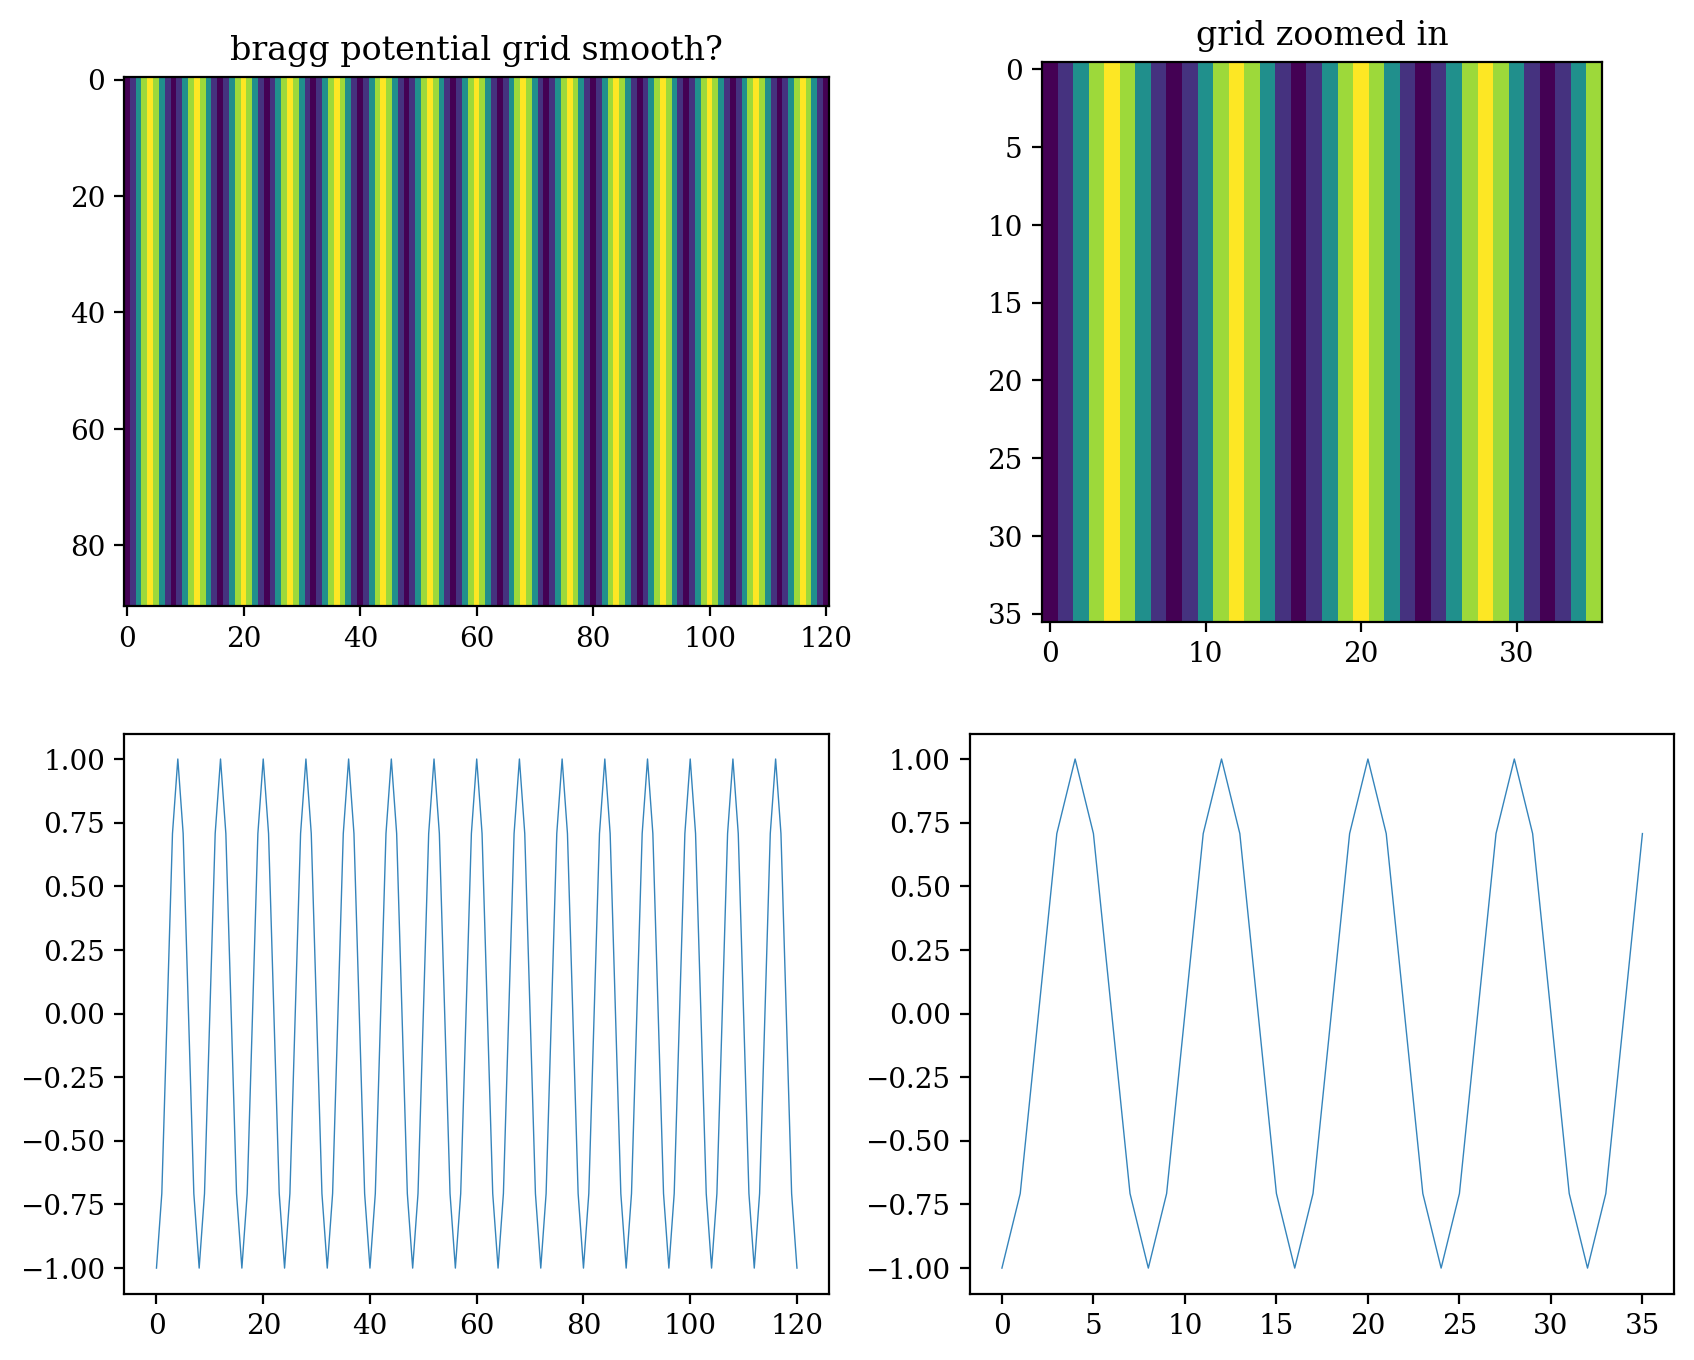

In [19]:
# vtest = np.cos(2*k*xlin)
ncrop = int(0.3*nx)
plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
plt.imshow(cosXGrid.T)
plt.title("bragg potential grid smooth?")

plt.subplot(2,2,2)
plt.imshow(cosXGrid[:ncrop,:ncrop].T)
plt.title("grid zoomed in")

plt.subplot(2,2,3)
plt.plot(cosXGrid[:,0],alpha=0.9,linewidth=0.5)

plt.subplot(2,2,4)
plt.plot(cosXGrid[:ncrop,0],alpha=0.9,linewidth=0.5)

title="bragg_potential_grid"
# plt.savefig("output/"+title+".pdf", dpi=600)
# plt.savefig("output/"+title+".png", dpi=600)

plt.show()
del ncrop

## initial wave function

In [25]:
sg = 8;
def psi0gaussianNN(x3, z3, x4, z4, sx3=sg, sz3=sg, sx4=sg, sz4=sg, px3=0, pz3=0, px4=0, pz4=0):
    return    np.exp(-0.5*x3**2/sx3**2)\
            * np.exp(-0.5*z3**2/sz3**2)\
            * np.exp(-0.5*x4**2/sx4**2)\
            * np.exp(-0.5*z4**2/sz4**2)\
            * np.exp(+(1j/hb)*(px3*x3 + pz3*z3 + px4*x4 + pz4*z4))

def check_norm(psi):
    return np.trapz(np.trapz(np.trapz(np.trapz(np.abs(psi)**2,dx=dz,axis=3),dx=dx,axis=2),dx=dz,axis=1),dx=dx,axis=0)

def psi0gaussian(sx3=sg, sz3=sg, sx4=sg, sz4=sg, px3=0, pz3=0, px4=0, pz4=0):
    psi=np.zeros((nx,nz, nx,nz),dtype=np.clongdouble)
    for (iz3, z3) in enumerate(zlin):
        for (ix4, x4) in enumerate(xlin):
            for (iz4, z4) in enumerate(zlin):
                psi[:,iz3,ix4,iz4] = psi0gaussianNN(xlin, z3, x4, z4,sx3,sz3,sx4,sz4,px3,pz3,px4,pz4)
    normalisation = check_norm(psi)
    return psi/sqrt(normalisation)

def only3(psi):
    return np.trapz(np.trapz(np.abs(psi)**2 ,dx=dz,axis=3),dx=dx,axis=2)
def only4(psi):
    return np.trapz(np.trapz(np.abs(psi)**2 ,dx=dx,axis=0),dx=dz,axis=0)



In [ ]:
def psi0gaussianPair(x3,z3,x4,z4,r3=10,r4=10*3/4,s3=3,s4=3,p3=hb*k,p4=hb*k):
    return np.exp()

In [26]:
np.finfo(np.clongdouble)

finfo(resolution=1e-15, min=-1.7976931348623157e+308, max=1.7976931348623157e+308, dtype=float64)

In [27]:
np.finfo(np.cdouble)

finfo(resolution=1e-15, min=-1.7976931348623157e+308, max=1.7976931348623157e+308, dtype=float64)

In [28]:
np.finfo(np.csingle)

finfo(resolution=1e-06, min=-3.4028235e+38, max=3.4028235e+38, dtype=float32)

#### Testings

In [20]:
psi.dtype

dtype('complex128')

## FFT to momentum

In [29]:
def only3phi(phi):
    return np.trapz(np.trapz(np.abs(phi)**2,dx=dpz,axis=3),dx=dpx,axis=2)
def only4phi(phi):
    return np.trapz(np.trapz(np.abs(phi)**2,dx=dpx,axis=0),dx=dpz,axis=0)
def check_norm_phi(phi):
    return np.trapz(np.trapz(np.trapz(np.trapz(np.abs(phi)**2,dx=dpz,axis=3),dx=dpx,axis=2),dx=dpz,axis=1),dx=dpx,axis=0)


In [30]:
def phiAndSWNF(psi):
    phiUN = np.fliplr(np.fft.fftshift(pyfftw.interfaces.numpy_fft.fftn(psi,threads=nthreads,norm='ortho')))
    superWeirdNormalisationFactorSq = check_norm_phi(phiUN)
    swnf = sqrt(superWeirdNormalisationFactorSq)
    phi = phiUN/swnf
    return phi, swnf
def toPhi(psi, swnf):
    return np.fliplr(np.fft.fftshift(pyfftw.interfaces.numpy_fft.fftn(psi,threads=nthreads,norm='ortho')))/swnf
def toPsi(phi, swnf):
    return pyfftw.interfaces.numpy_fft.ifftn(np.fft.ifftshift(np.fliplr(phi*swnf)),threads=nthreads,norm='ortho')

In [ ]:
del t, psi, phi, swnf

In [31]:
def numericalEvolve_plotHelper(t, psi, phi):
    plt.figure(figsize=(12,6))
    plt.subplot(2,2,1)
    plt.imshow(only3(psi).T)

    plt.subplot(2,2,2)
    plt.imshow(only4(psi).T)

    plt.subplot(2,2,3)
    plt.imshow(only3phi(phi).T, extent=[-pxmax,pxmax,-pzmax,pzmax])

    plt.subplot(2,2,4)
    plt.imshow(only4phi(phi).T, extent=[-pxmax,pxmax,-pzmax,pzmax])

    plt.show()

def numericalEvolve(
        t_init, 
        psi_init, 
        t_final, 
        tPi  = tBraggPi, 
        tMid = tBraggPi*5, 
        V0FArg=V0F,
        phase  = 0,
        doppd=dopd,
        print_every_t=-1, 
        final_plot=True,
        progress_bar=True, 
    ):
    assert (print_every_t >= dt or print_every_t <= 0), "print_every_t cannot be smaller than dt"
    steps = ceil((t_final - t_init) / dt) 
    t = t_init
    psi = psi_init.copy()
    del psi_init
#     psi = psi_init
    (phi, swnf) = phiAndSWNF(psi)

    def loop():
        nonlocal t
        nonlocal psi
        nonlocal phi
        Vx3ExpGrid = np.exp(-(1j/hb) * 0.5*dt * VBF(t,tMid,tPi,V0FArg) * 
                            np.cos(2*k*x3grid + doppd*(t-tMid) + phase) )
        Vx4ExpGrid = np.exp(-(1j/hb) * 0.5*dt * VBF(t,tMid,tPi,V0FArg) * 
                            np.cos(2*k*x4grid + doppd*(t-tMid) + phase) )
        psi *= Vx3ExpGrid
        psi *= Vx4ExpGrid
        phi = toPhi(psi,swnf)
        phi *= expP3Grid
        phi *= expP4Grid
        psi = toPsi(phi,swnf)
        psi *= Vx3ExpGrid
        psi *= Vx4ExpGrid
        
        t += dt 
        
    if progress_bar:
        for step in tqdm(range(steps)):
            loop()
            print("finished step =", step, "\t memory used: " + 
                  str(round(current_py_memory()/1000**2,3)) + "MB  ", end='\r');
            if print_every_t > 0 and step % round(print_every_t / dt) == 0: 
                numericalEvolve_plotHelper(t, psi, phi)
    else:
        for step in range(steps):
            loop()
    
    if final_plot:
        print("ALL DONE")
        numericalEvolve_plotHelper(t, psi, phi)
    return (t,psi,phi)

In [34]:
su = 5
(t_try1, psi_try1, phi_try1) = numericalEvolve(t_init=0, 
                psi_init=psi0gaussian(sx3=su, sz3=su, sx4=su, sz4=su, px3=0, pz3=0, px4=0, pz4=0), 
                t_final=tauEnd, tPi=tauPi, tMid=tauMid, V0FArg=1*V0F, phase=0, doppd=-10*dopd, 
                print_every_t=0*dt, final_plot=False, progress_bar=True)

  0%|          | 0/39 [00:00<?, ?it/s]

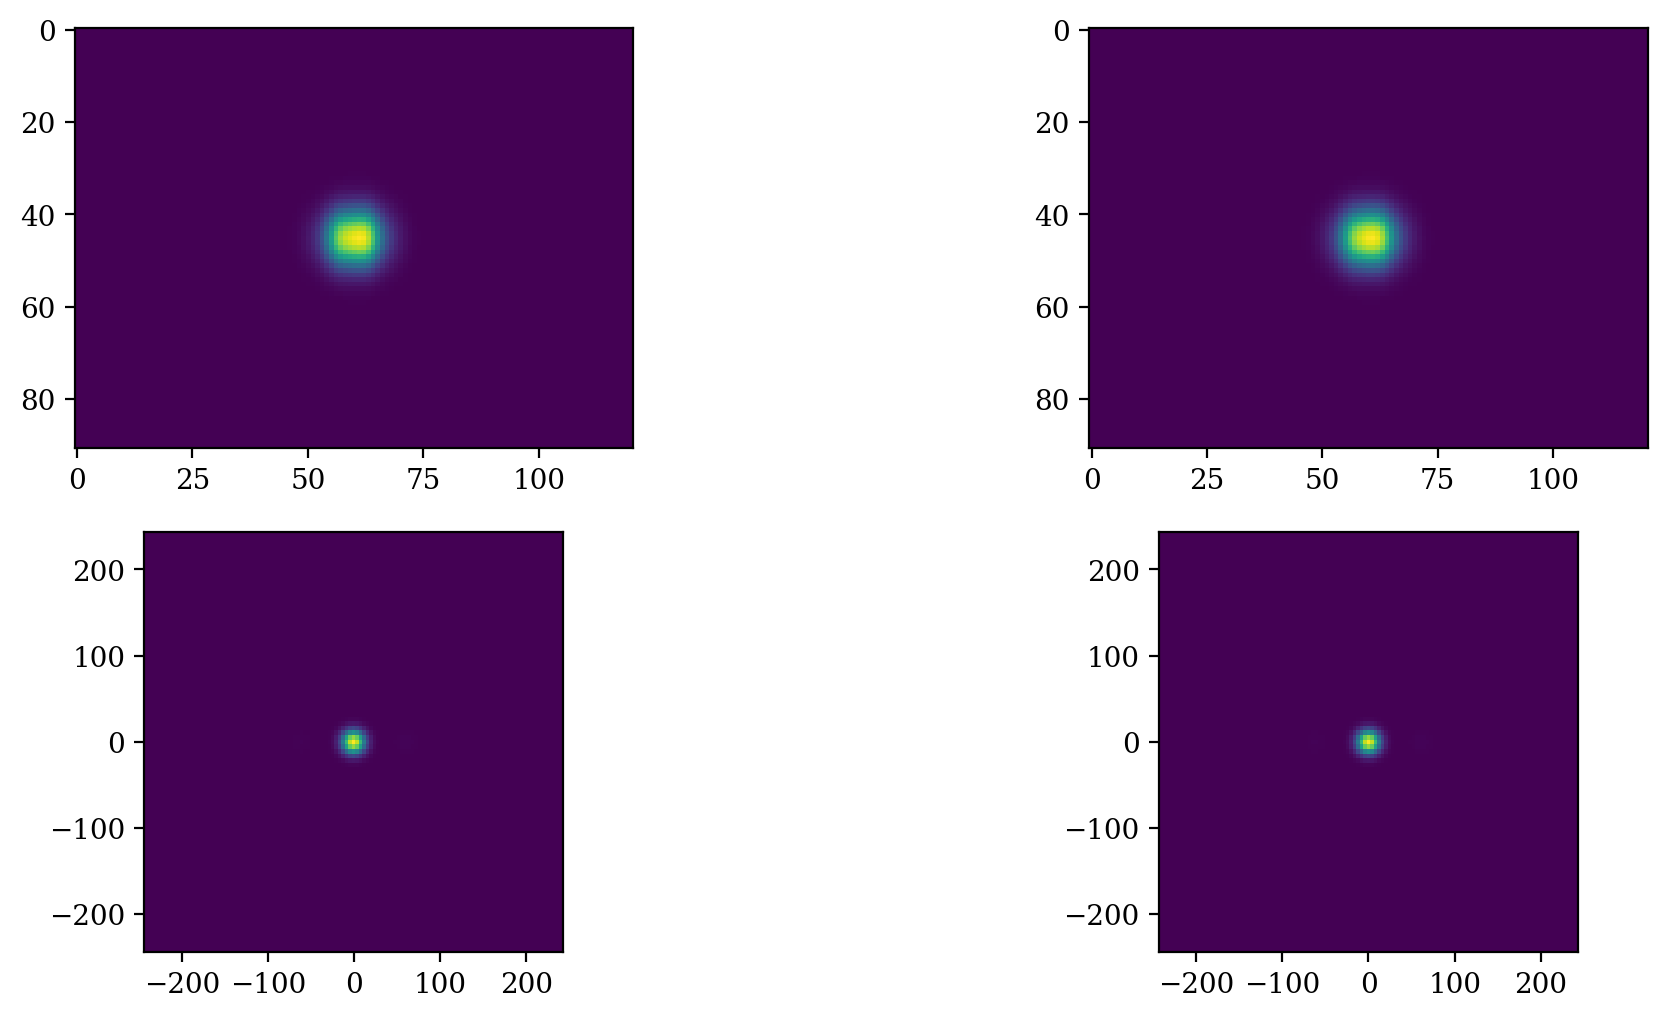

In [37]:
numericalEvolve_plotHelper(t_try1, psi_try1, phi_try1)

In [32]:
hbar_k_transfers = np.arange(-6,6+1)
pzlinIndexSet = np.zeros((len(hbar_k_transfers), len(pxlin)), dtype=bool)
# cut_p_width = 0.1
lr_include = 1
for (j, hbar_k) in enumerate(hbar_k_transfers):
#     pzlinIndexSet[j] = abs(pxlin/(hb*k) - hbar_k) <= cut_p_width

    index_unshift = round(hbar_k*(hb*k)/dpx)
    index = int(index_unshift + (nx-1)/2)
    for ishift in range(-lr_include, lr_include+1):
        pzlinIndexSet[j,index+ishift] = True
    
#     print(i,hbar_k, index)

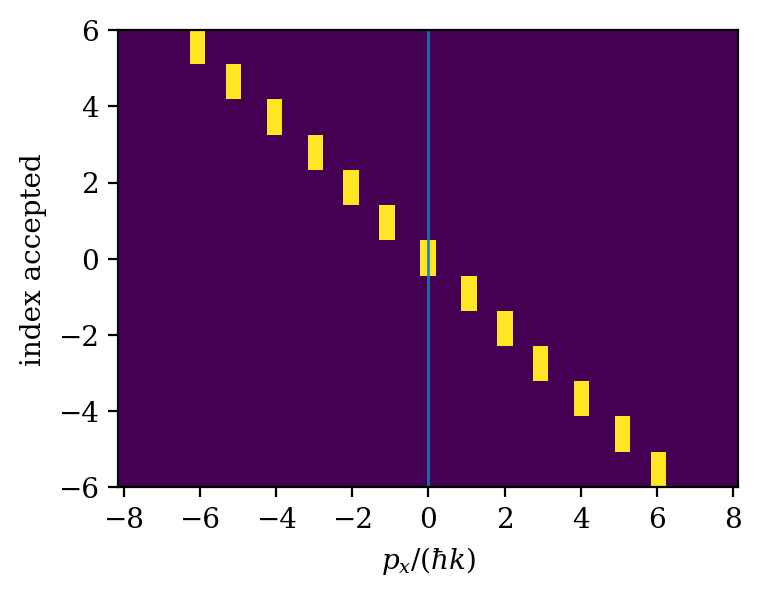

In [33]:
# plt.figure()
ax = plt.figure(figsize=(4,4)).gca()
plt.imshow(pzlinIndexSet,interpolation='none',aspect=1, extent=[-pxmax/(hb*k),pxmax/(hb*k),-6,+6])
# plt.axvline(x=(nx-1)/2, linewidth=1, alpha=0.1)
plt.axvline(x=0, linewidth=1, alpha=0.9)
plt.xlabel("$p_x/(\hbar k)$")
plt.ylabel("index accepted")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

title="hbar_k_pxlin_integration_range"
# plt.savefig("output/"+title+".pdf", dpi=600)
# plt.savefig("output/"+title+".png", dpi=600)
plt.show()

In [40]:
phiDensityGrid_hbark = np.zeros(len(hbar_k_transfers))

In [43]:
phiX3 = np.trapz(np.trapz(np.trapz( (np.abs(phi_try1)**2) , pzlin,axis=3),pxlin,axis=2),pzlin,axis=1)
for (j, hbar_k) in enumerate(hbar_k_transfers):
    index = pzlinIndexSet[j]
    phiDensityGrid_hbark[j] = np.trapz(phiX3[index], pxlin[index])

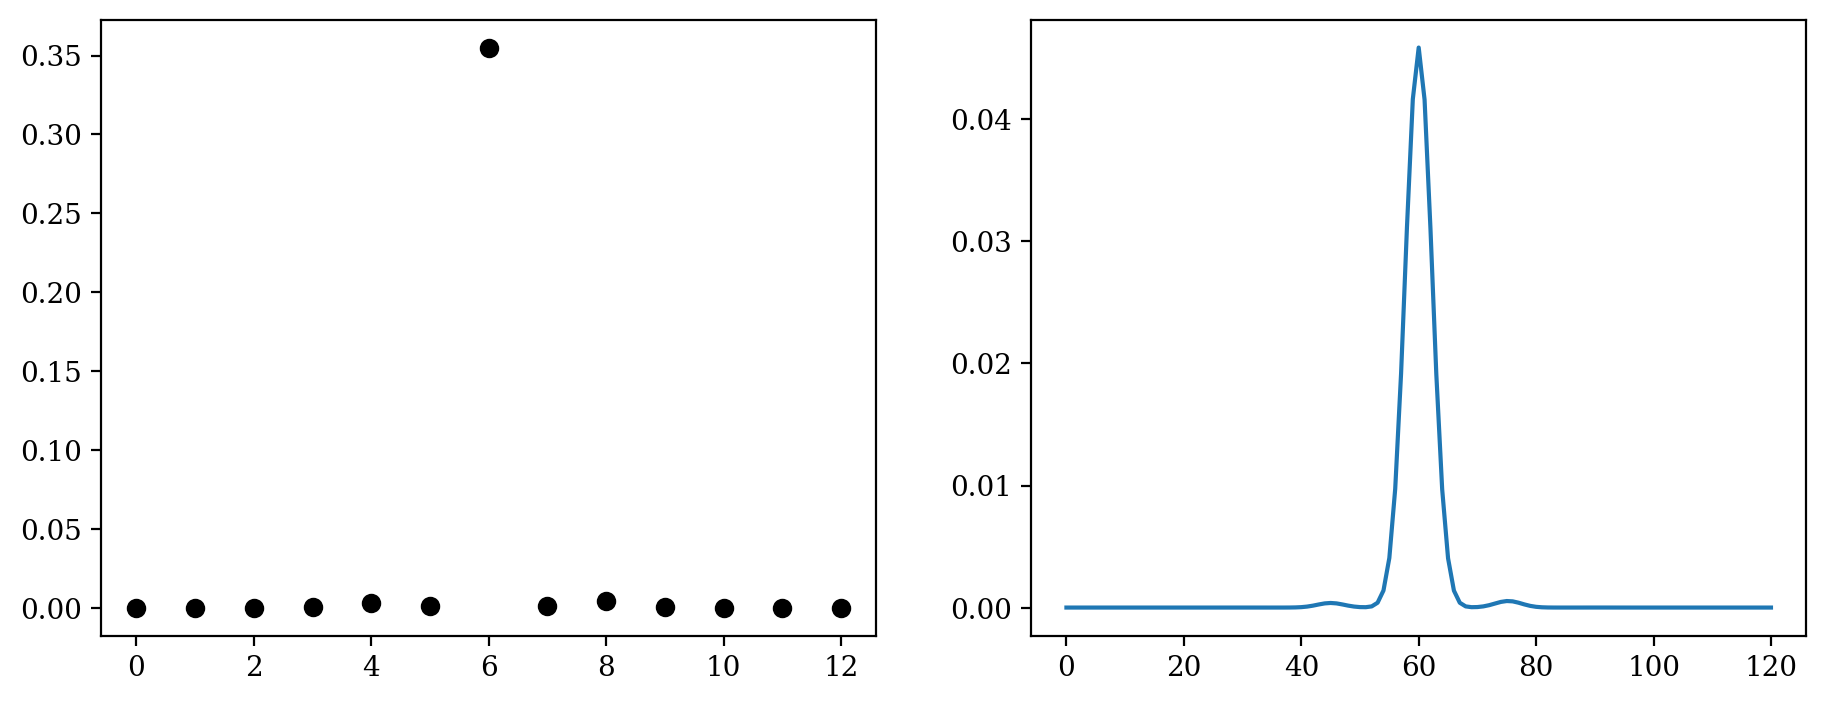

In [46]:
plt.figure(figsize=(11,4))
plt.subplot(1,2,1)
plt.plot(phiDensityGrid_hbark,'ko')
plt.subplot(1,2,2)
plt.plot(phiX3)

In [39]:
np.zeros(10)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [50]:
def scan_tauPi_init_gaussian(tPi, a3=0, a4=0, p3=0, p4=0, doppd=dopd, V0FArg=V0F, 
                             logging=False, progress_bar=False):
    tauPi  = tPi
    tauMid = tauPi * 5
    tauEnd = tauPi * 10
    px3 = p3*cos(a3)
    pz3 = p3*sin(a3)
    px4 = p4*cos(a4)
    pz4 = p4*sin(a4)
    
    if logging:
        print("Testing parameters")
        print("tauPi =", round(tPi,6), "    \t tauMid =", round(tauMid,6), " \t tauEnd = ", round(tauEnd,6))
    output = numericalEvolve(t_init=0, 
                psi_init=psi0gaussian(sx3=su, sz3=su, sx4=su, sz4=su, px3=px3, pz3=pz3, px4=px4, pz4=pz4), 
                t_final=tauEnd, tPi=tauPi, tMid=tauMid, V0FArg=V0FArg, phase=0, doppd=doppd, 
                print_every_t=0*dt, final_plot=False, progress_bar=progress_bar)
    

In [52]:
_ = scan_tauPi_init_gaussian(tauPi,a3=0,a4=0,p3=0,p4=0,doppd=-10*dopd,V0FArg=V0F,
                             logging=False,progress_bar=True)

  0%|          | 0/39 [00:00<?, ?it/s]

In [53]:
tPiTest = np.append(np.arange(0.015,0,-dt), 0) # note this is decending
    # tPiTest = np.arange(dt,3*dt,dt)  

In [55]:
tPiTest[[1,2,3]]

array([0.014, 0.013, 0.012])

In [ ]:
tPiOutput = Parallel(n_jobs=N_JOBS)(
    delayed(lambda tPi: (tPi, scan_tauPi_init_gaussian(tPi,a3=0,a4=0,p3=0,p4=0,doppd=-10*dopd,V0FArg=V0F,
                             logging=False,progress_bar=True)
           )(tPi) 
    for tPi in tqdm(tPiTest)
)     

In [ ]:
phiDensityGrid = np.zeros((len(tPiTest), pxlin.size))
phiDensityGrid_hbark = np.zeros((len(tPiTest),len(hbar_k_transfers)))

for i in tqdm(range(len(tPiTest))):
    item = tPiOutput[i]
    (swnf, phi) = phiAndSWNF(item[1][1])
    phiAbsSq = np.abs(phi)**2
    phiX = np.trapz(phiAbsSq, pzlin,axis=1)
    phiDensityGrid[i] = phiX

    for (j, hbar_k) in enumerate(hbar_k_transfers):
        index = pzlinIndexSet[j]
        phiDensityGrid_hbark[i,j] = np.trapz(phiX[index], pxlin[index])